## Import Library

In [59]:
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.layers import RandomFlip, RandomTranslation  # preprocessing layers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, Rescaling # model layers
from keras.models import Sequential, Model
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import glob, random
from PIL import Image
import numpy as np
import plotly.express as px
import seaborn as sns

import numpy as np

In [60]:
print(tf.__version__)

2.10.1


In [61]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Dataset

In [62]:
SEED = 1234
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 60
NUM_CLASSES = 7

train_dir = 'dataset/train/'
test_dir = 'dataset/test/'

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode='grayscale',
    label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode='categorical',
    shuffle=True,
    color_mode='grayscale',
    batch_size=BATCH_SIZE)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


## Data Visualization

### 1. Number of class

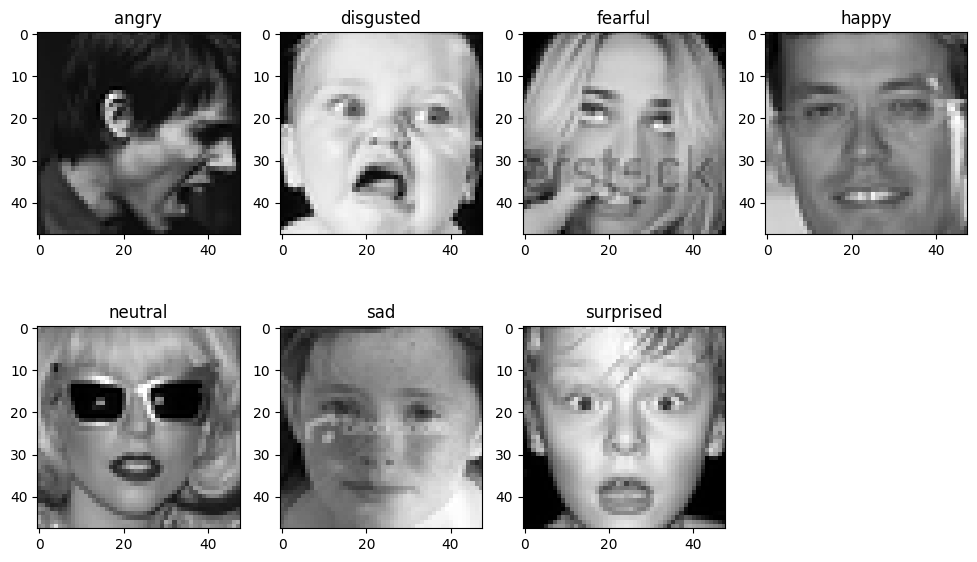

In [64]:
class_names = train_ds.class_names

plt.figure(figsize=(12,7))

for idx, class_name in enumerate(class_names):
    # get random file
    folder_path = os.path.join(train_dir, class_name)
    files = os.listdir(folder_path)
    random_file = random.choice(files)
    image = Image.open(os.path.join(folder_path, random_file))
    
    # draw random
    plt.subplot(2,4, idx+1)
    plt.imshow(image, cmap='gray')
    plt.title(class_name)
    
plt.show()

### 2. Data Distribution

<AxesSubplot: >

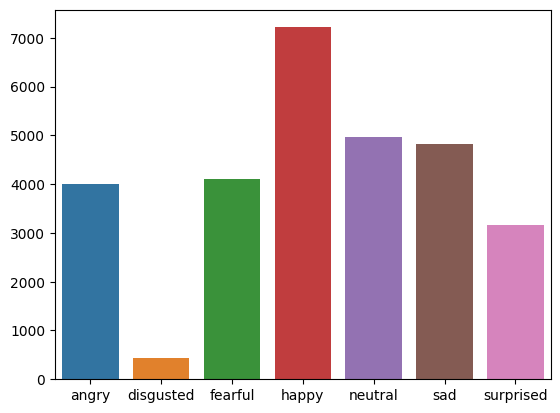

In [65]:
# count number of files each class name
values = np.array([ len(os.listdir(train_dir+i+'/')) for i in class_names ])
  
sns.barplot(x=class_names, y=values)

## Preprocess

In [66]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.05, 0.05),
])

### Visualize augmented images

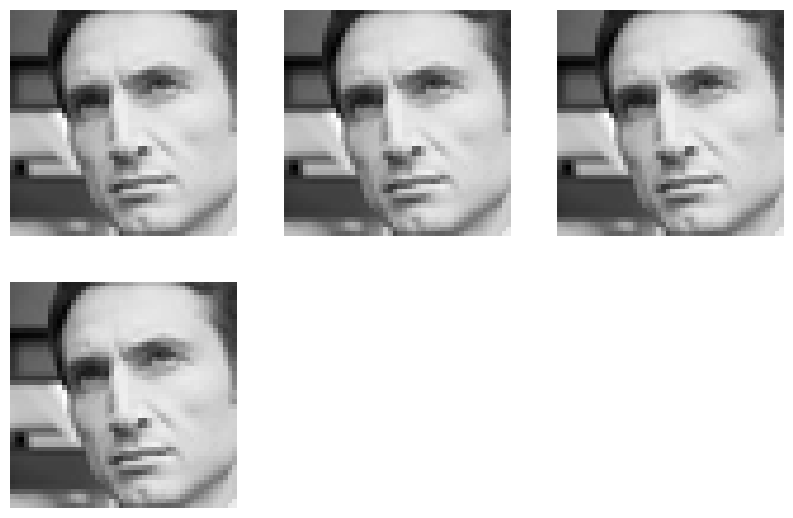

In [67]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(4):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

## Configure Dataset Performance

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

## Create Model

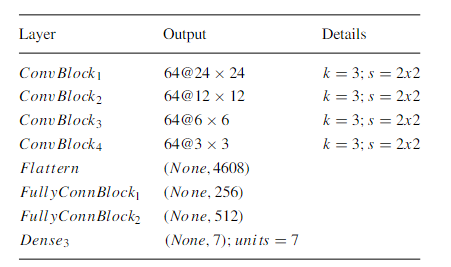

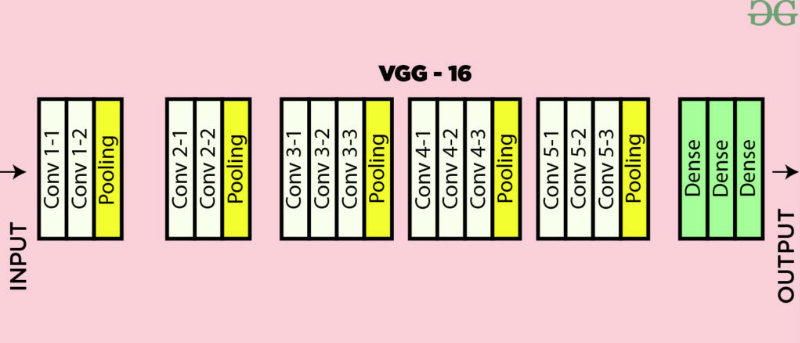

In [69]:
# The limitations for expression recognition in computer vision introduced by facial masks - Andrea Francesco Abate, Lucia Cimmino (https://link.springer.com/article/10.1007/s11042-022-13559-8#ref-CR24)

def feature_extractor(inputs):
    extractor = data_augmentation(inputs)
    extractor = Rescaling(1./255)(extractor)
    
    # Conv Block 1
    extractor = Conv2D(64, (3, 3), padding='same')(extractor)
    extractor = BatchNormalization()(extractor)
    extractor = Activation('relu')(extractor)
    extractor = MaxPooling2D(pool_size=(2, 2))(extractor)
    extractor = Dropout(0.25)(extractor)
    
    # Conv Block 2
    extractor = Conv2D(128, (5, 5), padding='same')(extractor)
    extractor = BatchNormalization()(extractor)
    extractor = Activation('relu')(extractor)
    extractor = MaxPooling2D(pool_size=(2, 2))(extractor)
    extractor = Dropout(0.25)(extractor)
    
    # Conv Block 3
    extractor = Conv2D(512, (3, 3), padding='same')(extractor)
    extractor = BatchNormalization()(extractor)
    extractor = Activation('relu')(extractor)
    extractor = MaxPooling2D(pool_size=(2, 2))(extractor)
    extractor = Dropout(0.25)(extractor)
    
    # Conv Block 4
    extractor = Conv2D(512, (3, 3), padding='same')(extractor)
    extractor = BatchNormalization()(extractor)
    extractor = Activation('relu')(extractor)
    extractor = MaxPooling2D(pool_size=(2, 2))(extractor)
    extractor = Dropout(0.25)(extractor)
    
    # Flatten for FC
    extractor = Flatten()(extractor)
    
    return extractor


def classifier(inputs):
    # FC Block 1
    x = Dense(256)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    # FC Block 2   
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    return x


inputs = Input(shape=(48, 48, 1))

outputs = feature_extractor(inputs)
outputs = classifier(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

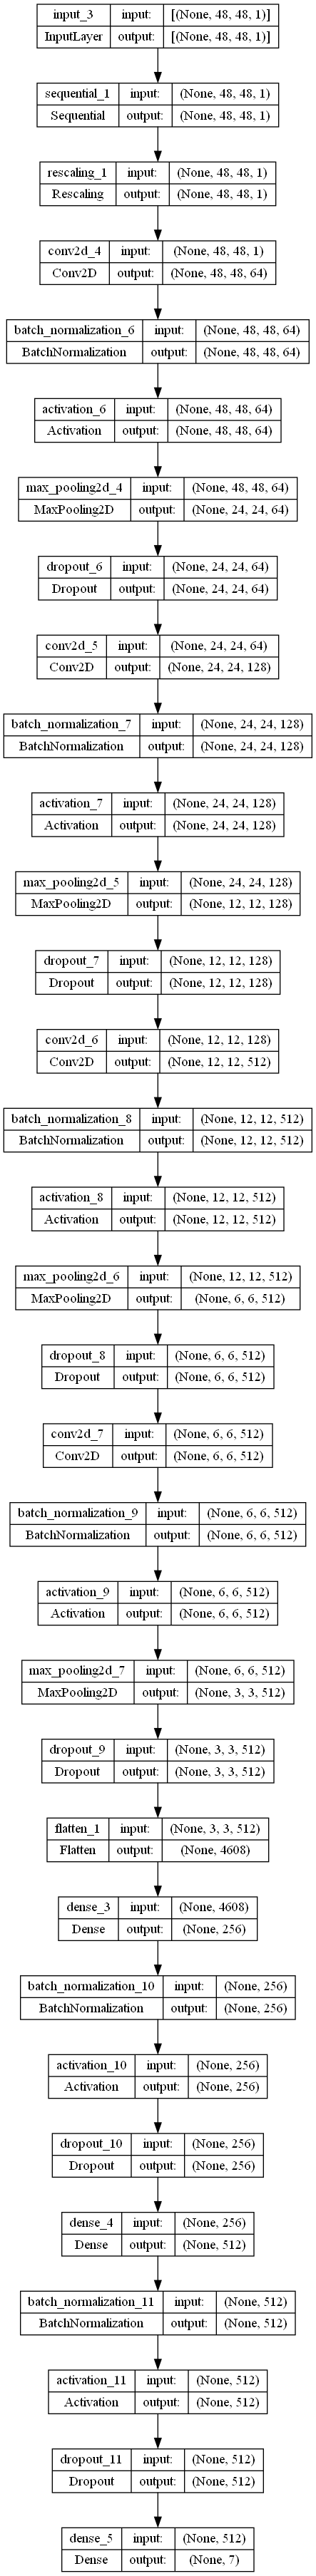

In [31]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                             

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [34]:
# save weights on checkpoint
checkpoint = ModelCheckpoint("model/model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint])

Epoch 1/60


c:\Users\erick\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


449/449 [==============================] - ETA: 0s - loss: 1.9878 - accuracy: 0.2376
Epoch 1: saving model to model\model_weights.h5
449/449 [==============================] - 196s 418ms/step - loss: 1.9878 - accuracy: 0.2376 - val_loss: 1.8778 - val_accuracy: 0.2520
Epoch 2/60
449/449 [==============================] - ETA: 0s - loss: 1.8235 - accuracy: 0.2899
Epoch 2: saving model to model\model_weights.h5
449/449 [==============================] - 186s 413ms/step - loss: 1.8235 - accuracy: 0.2899 - val_loss: 1.7168 - val_accuracy: 0.3422
Epoch 3/60
449/449 [==============================] - ETA: 0s - loss: 1.7392 - accuracy: 0.3252
Epoch 3: saving model to model\model_weights.h5
449/449 [==============================] - 186s 415ms/step - loss: 1.7392 - accuracy: 0.3252 - val_loss: 1.7530 - val_accuracy: 0.3600
Epoch 4/60
449/449 [==============================] - ETA: 0s - loss: 1.6550 - accuracy: 0.3584
Epoch 4: saving model to model\model_weights.h5
449/449 [=====================

In [36]:
# save model
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)

## Evaluate

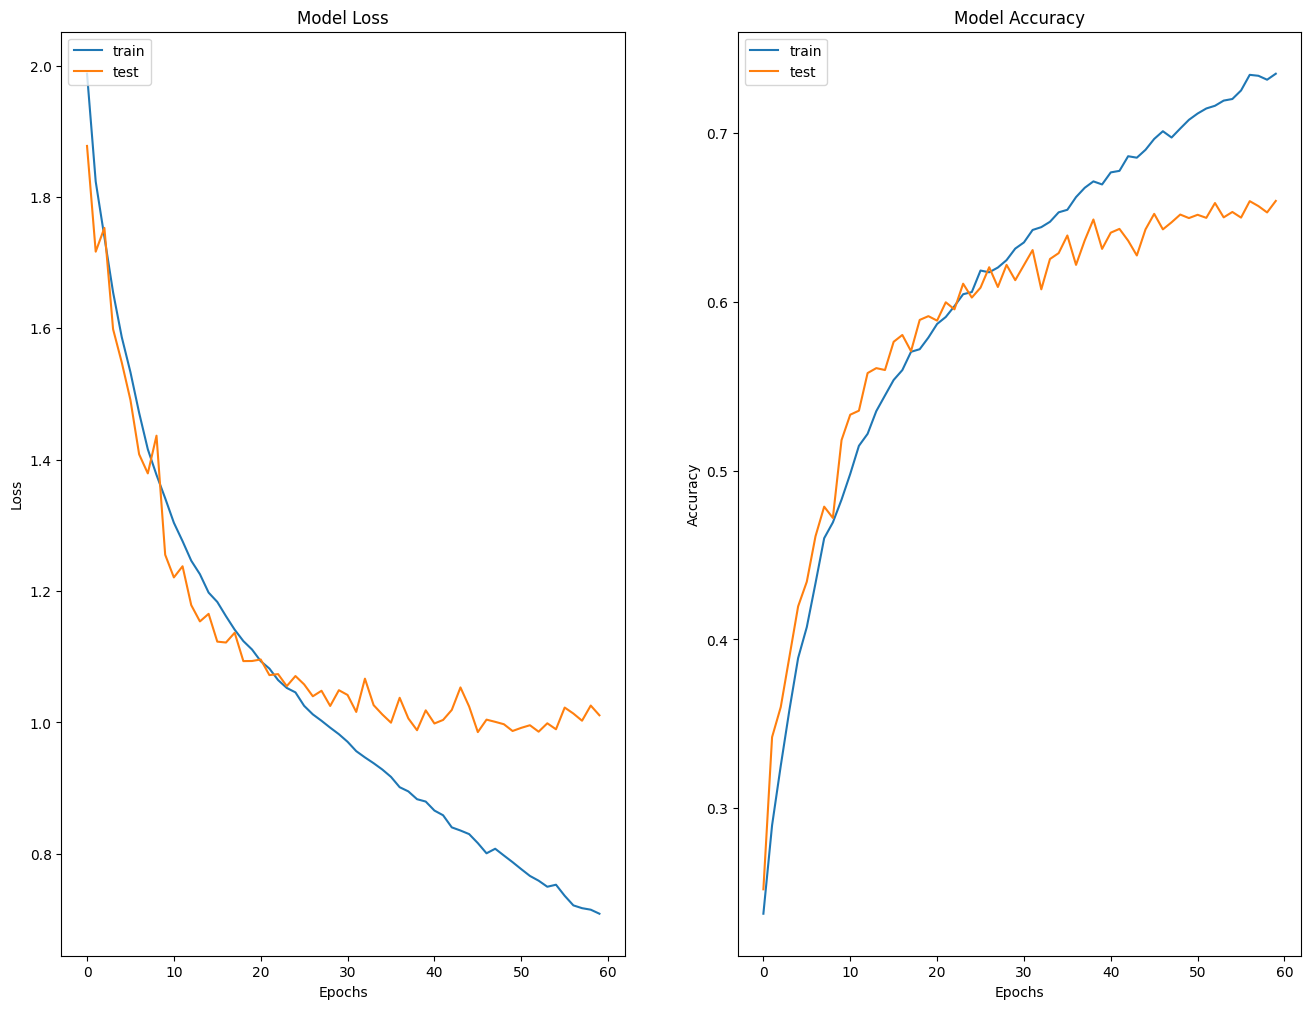

In [37]:
plt.figure(figsize=(16,12))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
